In [4]:
from neo4j import GraphDatabase
import pandas as pd
import yaml

In [8]:
with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

neo4j_config = config['neo4j']
print("Configuration chargée :")
print(f"URI: {neo4j_config['uri']}")
print(f"User: {neo4j_config['user']}")
print(f"Database: {neo4j_config['database']}")

Configuration chargée :
URI: neo4j://127.0.0.1:7687
User: neo4j
Database: neo4j


In [9]:
# Classe de connexion
class Neo4jConnector:
    def __init__(self, uri, user, password, database):
        self.driver = GraphDatabase.driver(uri, auth=(user, password))
        self.database = database

    def close(self):
        self.driver.close()

    def test_connection(self):
        try:
            with self.driver.session(database=self.database) as session:
                result = session.run("RETURN 1 AS test")
                return result.single()['test'] == 1
        except Exception as e:
            print(f" Erreur: {e}")
            return False

    def get_stats(self):
        query = """
        MATCH (a:Author)
        WITH count(a) AS num_authors
        MATCH (p:Paper)
        WITH num_authors, count(p) AS num_papers
        MATCH (a:Author)-[r:AUTHORED]->(p:Paper)
        RETURN num_authors, num_papers, count(r) AS num_authorships
        """
        with self.driver.session(database=self.database) as session:
            result = session.run(query)
            return dict(result.single())

In [10]:
connector = Neo4jConnector(
    uri=neo4j_config['uri'],
    user=neo4j_config['user'],
    password=neo4j_config['password'],
    database=neo4j_config['database']
)

if connector.test_connection():
    print("Connexion réussie à Neo4j!")
else:
    print("Échec de connexion")
    print("Vérifie que Neo4j est démarré et que le mot de passe est correct")


Unable to retrieve routing information


 Erreur: Unable to retrieve routing information
Échec de connexion
Vérifie que Neo4j est démarré et que le mot de passe est correct


In [1]:
stats = connector.get_stats()
print("\n Statistiques de la base de données:")
print(f"   Nombre d'auteurs: {stats['num_authors']}")
print(f"   Nombre de collaborations: {stats['num_authorships']}")
print(f"   Nombre de papers: {stats['num_papers']}")


NameError: name 'connector' is not defined

In [72]:
# Top 10 auteurs les plus prolifiques
query = """
MATCH (a:Author)-[:AUTHORED]->(p:Paper)
WITH a, count(p) AS num_papers
ORDER BY num_papers DESC
LIMIT 10
RETURN a.authorId AS authorId, a.name AS name, num_papers
"""

with connector.driver.session(database=connector.database) as session:
    result = session.run(query)
    top_authors = pd.DataFrame([dict(record) for record in result])

print("\n🏆 Top 10 auteurs :")
print(top_authors)



🏆 Top 10 auteurs :
    authorId             name  num_papers
0    1736651        S. Levine          54
1    1689992        P. Abbeel          41
2  145824029     David Silver          24
3    1751762    Yoshua Bengio          23
4    2645384   K. Kavukcuoglu          23
5    2827616       Quoc V. Le          22
6    2542999     T. Lillicrap          20
7    1689108       O. Vinyals          20
8    1746678  Shinji Watanabe          20
9   48987704      D. Hassabis          15


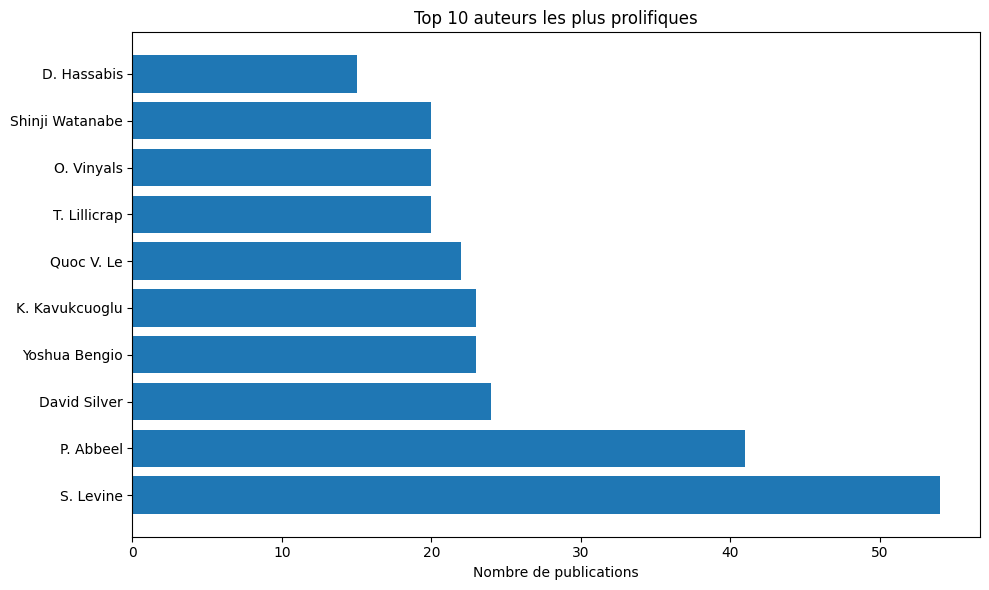

In [74]:
# Cellule 7 : Visualisation simple
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(top_authors['name'], top_authors['num_papers'])
plt.xlabel('Nombre de publications')
plt.title('Top 10 auteurs les plus prolifiques')
plt.tight_layout()
plt.show()

In [77]:
connector.close()
print("✅ Connexion fermée")

✅ Connexion fermée
